# Training a Jet Tagging with **Interaction Networks** 

---
In this notebook, we perform a Jet identification task using a graph-based multiclass classifier with INs.

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim

In [3]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [4]:
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

fatal: destination path 'tutorials' already exists and is not an empty directory.
jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [34]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    # for pT, eta, phi
    myJetList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
    # for px, py, pz
    #myJetList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 3)


In [35]:
# pytorch Cross Entropy doesn't support one-hot encoding
target = np.argmax(target, axis=1)
# the dataset is N_jets x N_particles x N_features
# the IN wants N_jets x N_features x N_particles
jetList = np.swapaxes(jetList, 1, 2)

The dataset consists of 50K with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [36]:
nParticle = 30
jetList = jetList[:,:,:nParticle]
print(jetList.shape)

(50000, 3, 30)


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 3, 30) (16500, 3, 30) (33500,) (16500,)


In [38]:
# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda"

In [39]:
# Convert dataset to pytorch
X_train = Variable(torch.FloatTensor(X_train)).to(device)
X_val = Variable(torch.FloatTensor(X_val)).to(device)
y_train = Variable(torch.LongTensor(y_train).long()).to(device)
y_val = Variable(torch.LongTensor(y_val).long()).to(device)

# Building the IN model

In [40]:
import itertools

class GraphNet(nn.Module):
    def __init__(self):
        super(GraphNet, self).__init__()
        self.P = 3 # number of features
        self.N = nParticle # number of particles
        self.Nr = self.N * (self.N - 1)
        self.De = 8 # dimensionality of De learned representation
        self.Do = 8 # number of engineered features
        self.n_targets = 5 # number of target classes
        self.assign_matrices() # build Rr and Rs

        # build netwok
        self.hidden = 10
        self.fr1 = nn.Linear(2 * self.P, self.hidden)
        self.fr2 = nn.Linear(self.hidden, self.hidden)
        self.fr3 = nn.Linear(self.hidden, self.De)
        self.fo1 = nn.Linear(self.P + self.De, self.hidden)
        self.fo2 = nn.Linear(self.hidden, self.hidden)
        self.fo3 = nn.Linear(self.hidden, self.Do)
        self.fc1 = nn.Linear(self.Do, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, self.n_targets)
             
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = Variable(self.Rr)
        self.Rs = Variable(self.Rs)

    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.De)))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C
        # sum over constituents
        O = torch.sum(O,1)
        ### Classification MLP ###
        N = nn.functional.relu(self.fc1(O.view(-1, self.Do)))
        N = nn.functional.relu(self.fc2(N))
        del O
        N = self.fc3(N)
        return N

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])

def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 50000)
    return training[chosen_ind], target[chosen_ind]

## Training

In [41]:
n_epochs = 300
batch_size = 100
patience =  10

In [42]:
gnn = GraphNet()
gnn.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)

loss_train = np.zeros(n_epochs)
acc_train = np.zeros(n_epochs)
loss_val = np.zeros(n_epochs)
acc_val = np.zeros(n_epochs)
for i in range(n_epochs):
    print("Epoch %s" % i)
    for j in range(0, X_train.size()[0], batch_size):
        optimizer.zero_grad()
        out = gnn(X_train[j:j + batch_size,:,:])
        target = y_train[j:j + batch_size]
        l = loss(out, target)
        l.backward()
        optimizer.step()
        loss_train[i] += l.cpu().data.numpy()*batch_size
    loss_train[i] = loss_train[i]/X_train.shape[0]
    #acc_train[i] = stats(predicted, Y_val)
    #### val loss & accuracy
    for j in range(0, X_val.size()[0], batch_size):
        out_val = gnn(X_val[j:j + batch_size])
        target_val =  y_val[j:j + batch_size]
        
        l_val = loss(out_val,target_val)
        loss_val[i] += l_val.cpu().data.numpy()*batch_size
    loss_val[i] = loss_val[i]/X_val.shape[0]
    print("Training   Loss: %f" %l.cpu().data.numpy())
    print("Validation Loss: %f" %l_val.cpu().data.numpy())
    if all(loss_val[max(0, i - patience):i] > min(np.append(loss_val[0:max(0, i - patience)], 200))) and i > patience:
        print("Early Stopping")
        break
    print

Epoch 0
Training   Loss: 1.585930
Validation Loss: 1.581979
Epoch 1
Training   Loss: 1.464135
Validation Loss: 1.456512
Epoch 2
Training   Loss: 1.444936
Validation Loss: 1.436243
Epoch 3
Training   Loss: 1.437727
Validation Loss: 1.422909
Epoch 4
Training   Loss: 1.429657
Validation Loss: 1.422964
Epoch 5
Training   Loss: 1.425260
Validation Loss: 1.411103
Epoch 6
Training   Loss: 1.424669
Validation Loss: 1.401849
Epoch 7
Training   Loss: 1.426191
Validation Loss: 1.392467
Epoch 8
Training   Loss: 1.427341
Validation Loss: 1.380121
Epoch 9
Training   Loss: 1.427552
Validation Loss: 1.375289
Epoch 10
Training   Loss: 1.428142
Validation Loss: 1.368384
Epoch 11
Training   Loss: 1.428591
Validation Loss: 1.361646
Epoch 12
Training   Loss: 1.428838
Validation Loss: 1.354960
Epoch 13
Training   Loss: 1.429137
Validation Loss: 1.351515
Epoch 14
Training   Loss: 1.429341
Validation Loss: 1.345540
Epoch 15
Training   Loss: 1.430220
Validation Loss: 1.342386
Epoch 16
Training   Loss: 1.429672

# Training history

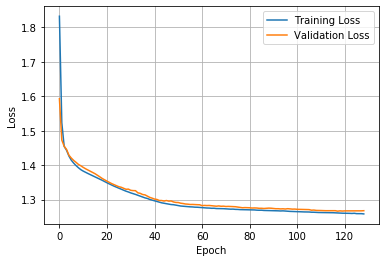

In [43]:
epoch_number = list(range((loss_train > 0.).sum()))
plt.figure()
plt.plot(epoch_number, loss_train[loss_train>0.],label='Training Loss')
plt.plot(epoch_number, loss_val[loss_train>0.],label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

# Building the ROC Curves

In [44]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

In [45]:
lst = []
n_batches_val = int(X_val.size()[0]/batch_size)
if args_cuda:    
    for j in torch.split(X_val, n_batches_val).cuda():
        a = gnn(j).cpu().data.numpy()
        lst.append(a)
else:
    for j in torch.split(X_val, n_batches_val):
        a = gnn(j).cpu().data.numpy()
        lst.append(a)
predicted = Variable(torch.FloatTensor(np.concatenate(lst)))

In [46]:
# there is no softmax in the output layer. We have to put it by 
predicted = torch.nn.functional.softmax(predicted, dim=1)

In [47]:
predict_val = predicted.data.numpy()
true_val = y_val.data.numpy()

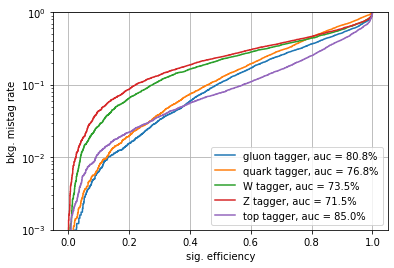

In [48]:
from sklearn.metrics import roc_curve, auc
#### get the ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val== i), predict_val[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()